# 09 - Lyrics + Spotify

In [98]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import RidgeCV, LogisticRegressionCV
from nltk.corpus import stopwords
from wordcloud import WordCloud

sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

## Load data

In [99]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

,artist_all,artist_base,rank,song,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,...,speechiness,tempo,time_signature,valence,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
1785,captain & tennille,captain and tennille,89,muskrat love,1977,NaN,muskrat love,captain and tennille,muskrat muskrat candlelight doin the town and ...,0.9260,...,0.0583,202.797,4.0,0.172,3.783333,124.0,0.546256,72.0,1970,1.722222
2310,duran duran,duran duran,17,hungry like the wolf,1983,NaN,hungry like the wolf,duran duran,dark in the city night is a wire steam in the...,0.0433,...,0.0558,127.568,4.0,0.685,3.677117,289.0,1.309903,87.0,1980,3.321839
308,kyu sakamoto,kyu sakamoto,10,sukiyaki,1963,NaN,sukiyaki,kyu sakamoto,上を向いて歩こう 涙がこぼれないように 思い出す春の日 一人ぼっちの夜 上を向いて歩こう に...,0.7070,...,0.0334,146.029,4.0,0.404,3.158667,23.0,0.121359,12.0,1960,1.916667


## Most \___ words

In [100]:
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

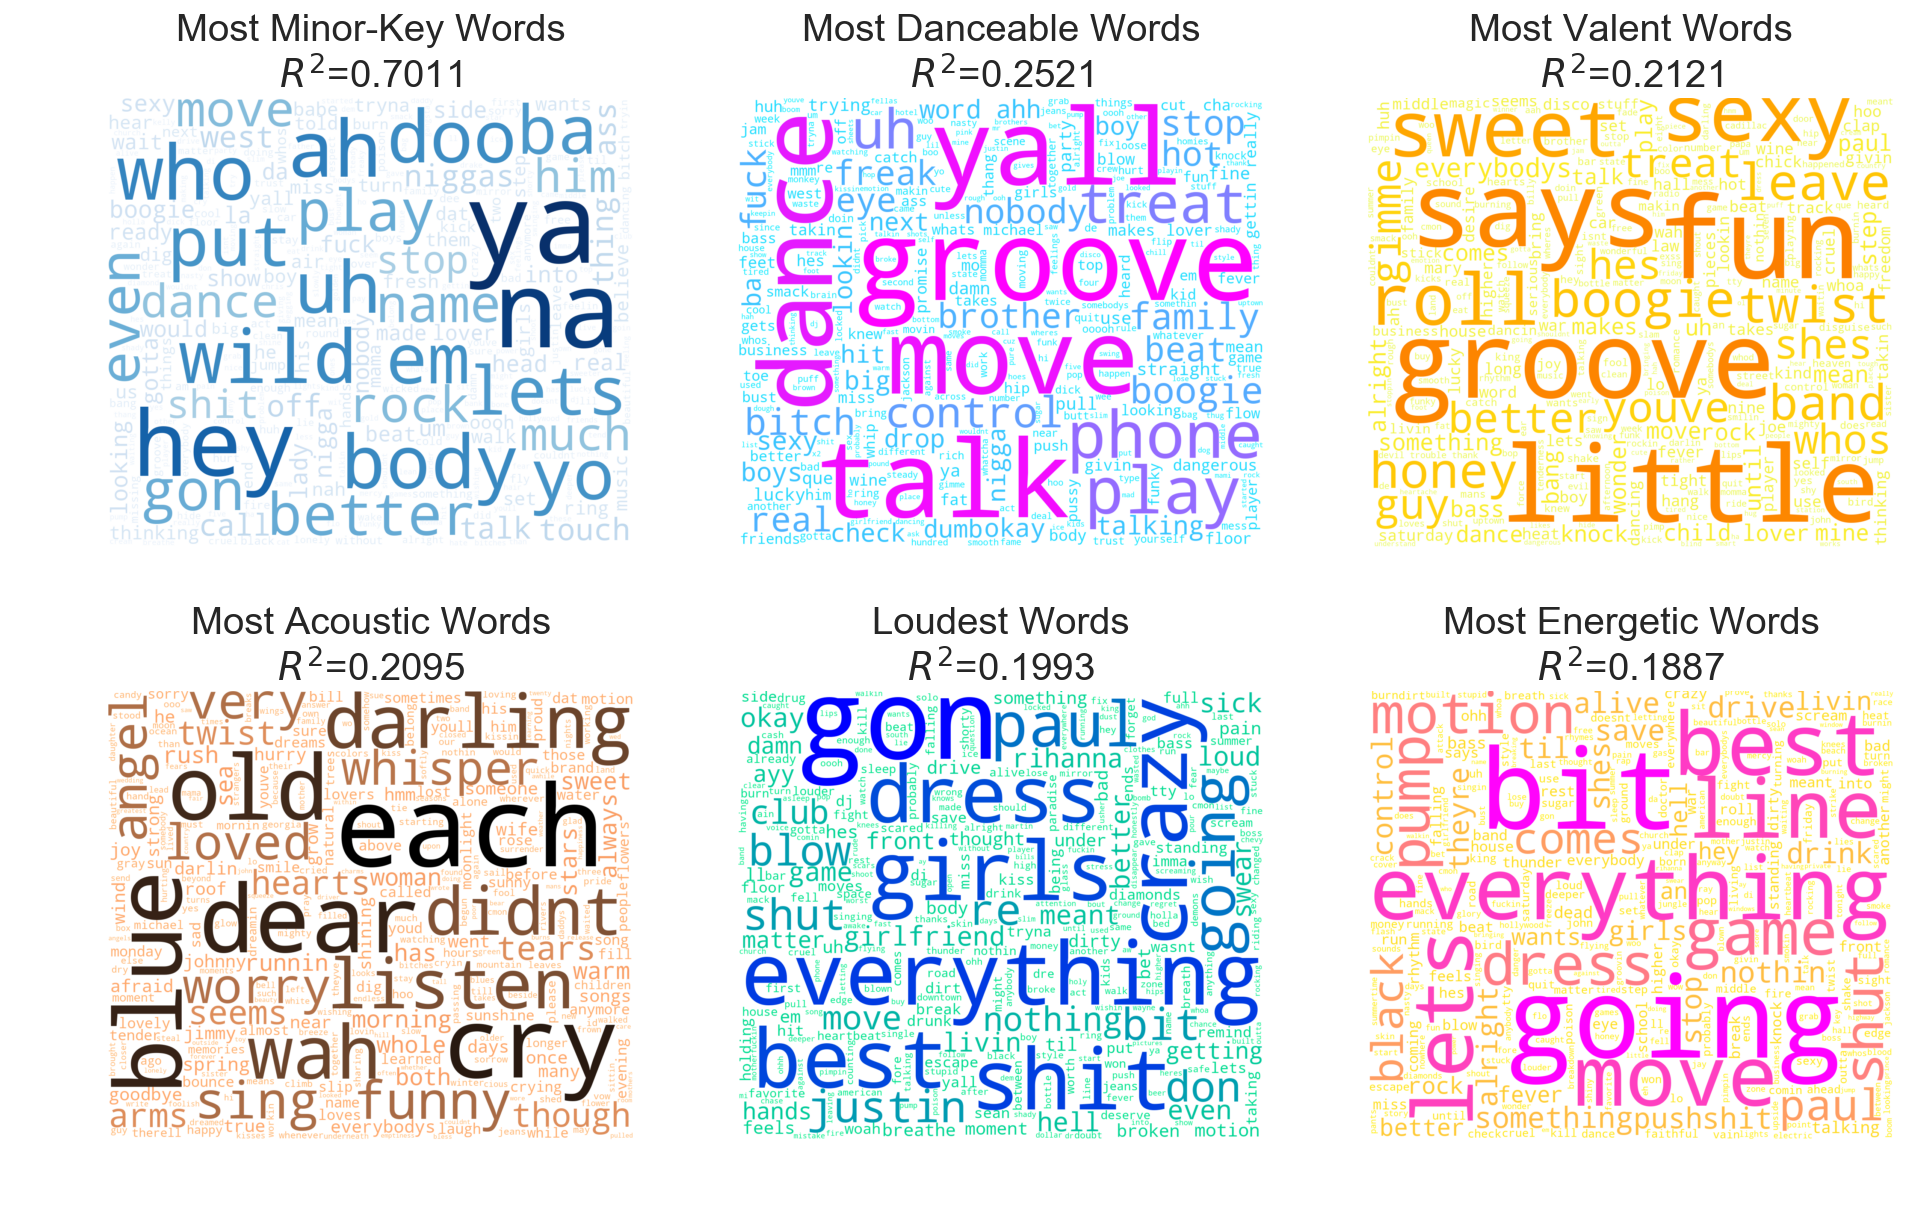

In [101]:
fig, axes = plt.subplots(2, 3, figsize=(16,10))
axes = axes.ravel()
audio_features = ['mode', 'danceability', 'valence', 'acousticness',
                  'loudness', 'energy']
titles = ['most minor-key words', 'most danceable words', 'most valent words',
          'most acoustic words', 'loudest words', 'most energetic words']

cmaps = ['Blues', 'cool', 'Wistia', 'copper_r', 'winter_r', 'spring_r']

count = CountVectorizer(min_df=20, max_df=1000)
X_vect = count.fit_transform(df_nonnull['lyrics'])
for i, feature in enumerate(audio_features):
    if feature != 'mode':
        ridge = RidgeCV(alphas=[1, 3, 10, 30, 1e2, 3e2, 1e3, 2e3, 3e3, 4e3, 1e5,
                                3e5, 1e6])
        ridge.fit(X_vect, df_nonnull[feature])
        score = ridge.score(X_vect, df_nonnull[feature])
    else:
        ridge = LogisticRegressionCV(Cs=[1e-6, 3e-6, 1e-5, 3e-5])
        ridge.fit(X_vect, 1 - df_nonnull[feature])
        score = ridge.scores_[1.].mean(axis=1).max()
    coefs = ridge.coef_
    if feature == 'mode':
        coefs = coefs.squeeze()
    vocab = count.get_feature_names()

    color_func = colormap_size_func(cmaps[i], 300)
    dictionary = dict(zip(vocab, coefs))
    wordcloud = WordCloud(background_color='white', height=1200,
                          min_font_size=5, width=1400, color_func=color_func,
                          max_words=300, relative_scaling=0.5,
                          max_font_size=300)
    wordcloud = wordcloud.generate_from_frequencies(dictionary)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set(title='{}\n$R^2$={:.4}'.format(titles[i], score).title())